<a href="https://colab.research.google.com/github/kuldeepmishra92/Airline-Project/blob/main/airlineproject2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from tqdm.notebook import tqdm
from sklearn.linear_model import LinearRegression



In [ ]:
plt.style.use('ggplot')

In [ ]:
df=pd.read_csv("/content/preprocessed_airline_dataset.csv")
df.head()

,header,author,date,place,content,aircraft,traveller_type,seat_type,route,date_flown,recommended,trip_verified,rating,seat_comfort,cabin_staff_service,food_beverages,ground_service,value_for_money,entertainment
0,service was mediocre at best,Gary Storer,03-10-2023,United Kingdom,"Just returned from Chicago, flew out 10 days ...",A380,Couple Leisure,Economy Class,Chicago to Manchester via Heathrow,01-10-2023,no,Not Verified,2,2,3,1,2,2,-1
1,BA standards continue to decline,A Jensen,02-10-2023,United Kingdom,BA standards continue to decline every time ...,A320,Business,Business Class,London Heathrow to Munich,01-09-2023,no,Verified,2,2,1,2,1,1,-1
2,"won the race to the bottom""",John Rockett,02-10-2023,United Kingdom,Awful. Business class check in queue just as...,A320,Couple Leisure,Business Class,Heathrow to Istanbul,01-09-2023,no,Not Verified,2,2,3,2,1,1,-1
3,Not a reliable airline,Tatiana Bobrovskaya,02-10-2023,United Kingdom,Not a reliable airline. You cannot trust the...,A320,Business,Economy Class,London to Geneva,01-10-2023,no,Verified,3,4,4,2,1,1,-1
4,Very disappointed,Tom Slowbe,28-09-2023,United States,"The airplanes and the lounges are worn out, o...",777-300 and A320,Couple Leisure,First Class,Dallas to Dubrovnik via Heathrow,01-09-2023,no,Verified,1,1,4,4,3,2,3


In [ ]:
# @title date vs rating

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['rating']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('traveller_type')):
  _plot_series(series, series_name, i)
  fig.legend(title='traveller_type', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('rating')

# New Section

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['content']
        myid = row['header']
        roberta_result = polarity_scores_roberta(text)
        both = {**roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/1324 [00:00<?, ?it/s]

Broke for id it's by no measure good
Broke for id found the attitude appalling" 
Broke for id the worst business class experience I've ever had
Broke for id you can and need to do better than this
Broke for id Who’d have thought BA could ever make Ryanair look like an attractive option
Broke for id very disappointing service
Broke for id roller coaster of incompetence
Broke for id flight has improved my opinion on British Airways
Broke for id both involuntarily downgraded
Broke for id The most miserable rip off
Broke for id offer some additional comfort
Broke for id so much BA could do to improve
Broke for id This was a great flight
Broke for id thoroughly recommend it
Broke for id improved on board experience
Broke for id  a very acceptable flight
Broke for id gone notably downhill
Broke for id they understand my frustration
Broke for id IFE is a work of mystery
Broke for id years have not been kind
Broke for id crew very friendly and professional
Broke for id need to roll out promise

In [ ]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'header'})
results_df = results_df.merge(df, how='left')

In [ ]:
results_df.head()

,header,roberta_neg,roberta_neu,roberta_pos,author,date,place,content,aircraft,traveller_type,...,date_flown,recommended,trip_verified,rating,seat_comfort,cabin_staff_service,food_beverages,ground_service,value_for_money,entertainment
0,service was mediocre at best,0.425968,0.320773,0.253260,Gary Storer,03-10-2023,United Kingdom,"Just returned from Chicago, flew out 10 days ...",A380,Couple Leisure,...,01-10-2023,no,Not Verified,2,2,3,1,2,2,-1
1,BA standards continue to decline,0.864413,0.119711,0.015876,A Jensen,02-10-2023,United Kingdom,BA standards continue to decline every time ...,A320,Business,...,01-09-2023,no,Verified,2,2,1,2,1,1,-1
2,"won the race to the bottom""",0.900951,0.085384,0.013665,John Rockett,02-10-2023,United Kingdom,Awful. Business class check in queue just as...,A320,Couple Leisure,...,01-09-2023,no,Not Verified,2,2,3,2,1,1,-1
3,Not a reliable airline,0.848576,0.135319,0.016105,Tatiana Bobrovskaya,02-10-2023,United Kingdom,Not a reliable airline. You cannot trust the...,A320,Business,...,01-10-2023,no,Verified,3,4,4,2,1,1,-1
4,Very disappointed,0.967972,0.029027,0.003001,Tom Slowbe,28-09-2023,United States,"The airplanes and the lounges are worn out, o...",777-300 and A320,Couple Leisure,...,01-09-2023,no,Verified,1,1,4,4,3,2,3


In [ ]:
results_df.to_csv("abc.csv")

In [ ]:
results_df

,header,roberta_neg,roberta_neu,roberta_pos,author,date,place,content,aircraft,traveller_type,...,date_flown,recommended,trip_verified,rating,seat_comfort,cabin_staff_service,food_beverages,ground_service,value_for_money,entertainment
0,service was mediocre at best,0.425968,0.320773,0.253260,Gary Storer,03-10-2023,United Kingdom,"Just returned from Chicago, flew out 10 days ...",A380,Couple Leisure,...,01-10-2023,no,Not Verified,2,2,3,1,2,2,-1
1,BA standards continue to decline,0.864413,0.119711,0.015876,A Jensen,02-10-2023,United Kingdom,BA standards continue to decline every time ...,A320,Business,...,01-09-2023,no,Verified,2,2,1,2,1,1,-1
2,"won the race to the bottom""",0.900951,0.085384,0.013665,John Rockett,02-10-2023,United Kingdom,Awful. Business class check in queue just as...,A320,Couple Leisure,...,01-09-2023,no,Not Verified,2,2,3,2,1,1,-1
3,Not a reliable airline,0.848576,0.135319,0.016105,Tatiana Bobrovskaya,02-10-2023,United Kingdom,Not a reliable airline. You cannot trust the...,A320,Business,...,01-10-2023,no,Verified,3,4,4,2,1,1,-1
4,Very disappointed,0.967972,0.029027,0.003001,Tom Slowbe,28-09-2023,United States,"The airplanes and the lounges are worn out, o...",777-300 and A320,Couple Leisure,...,01-09-2023,no,Verified,1,1,4,4,3,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1261,better than most shorthaul,0.038636,0.252112,0.709251,John Rolfe,27-03-2016,United Kingdom,Gatwick to Seville with British Airways. Fli...,A319,Family Leisure,...,01-03-2016,yes,Verified,9,3,4,3,4,4,-1
1262,seat let down very good flight,0.062700,0.171750,0.765550,Gregory Martinez,26-03-2016,United Kingdom,Barcelona to Seoul Incheon via London Heathr...,Boeing 787,Solo Leisure,...,01-03-2016,yes,Verified,8,3,4,4,4,5,4
1263,BA.com been truly appalling,0.800704,0.174333,0.024963,Joanne Le Bon,24-03-2016,United Kingdom,We have flown with British Airways over 100 ...,Boeing 747-400,Couple Leisure,...,01-03-2016,no,Verified,8,3,4,3,4,2,3
1264,overall experience was pleasant,0.186199,0.364578,0.449223,J Lawrence,23-03-2016,South Africa,British Airways from Seattle to Johannesburg...,Boeing 747-400 /A380,Solo Leisure,...,01-03-2016,yes,Verified,8,3,4,4,4,4,2


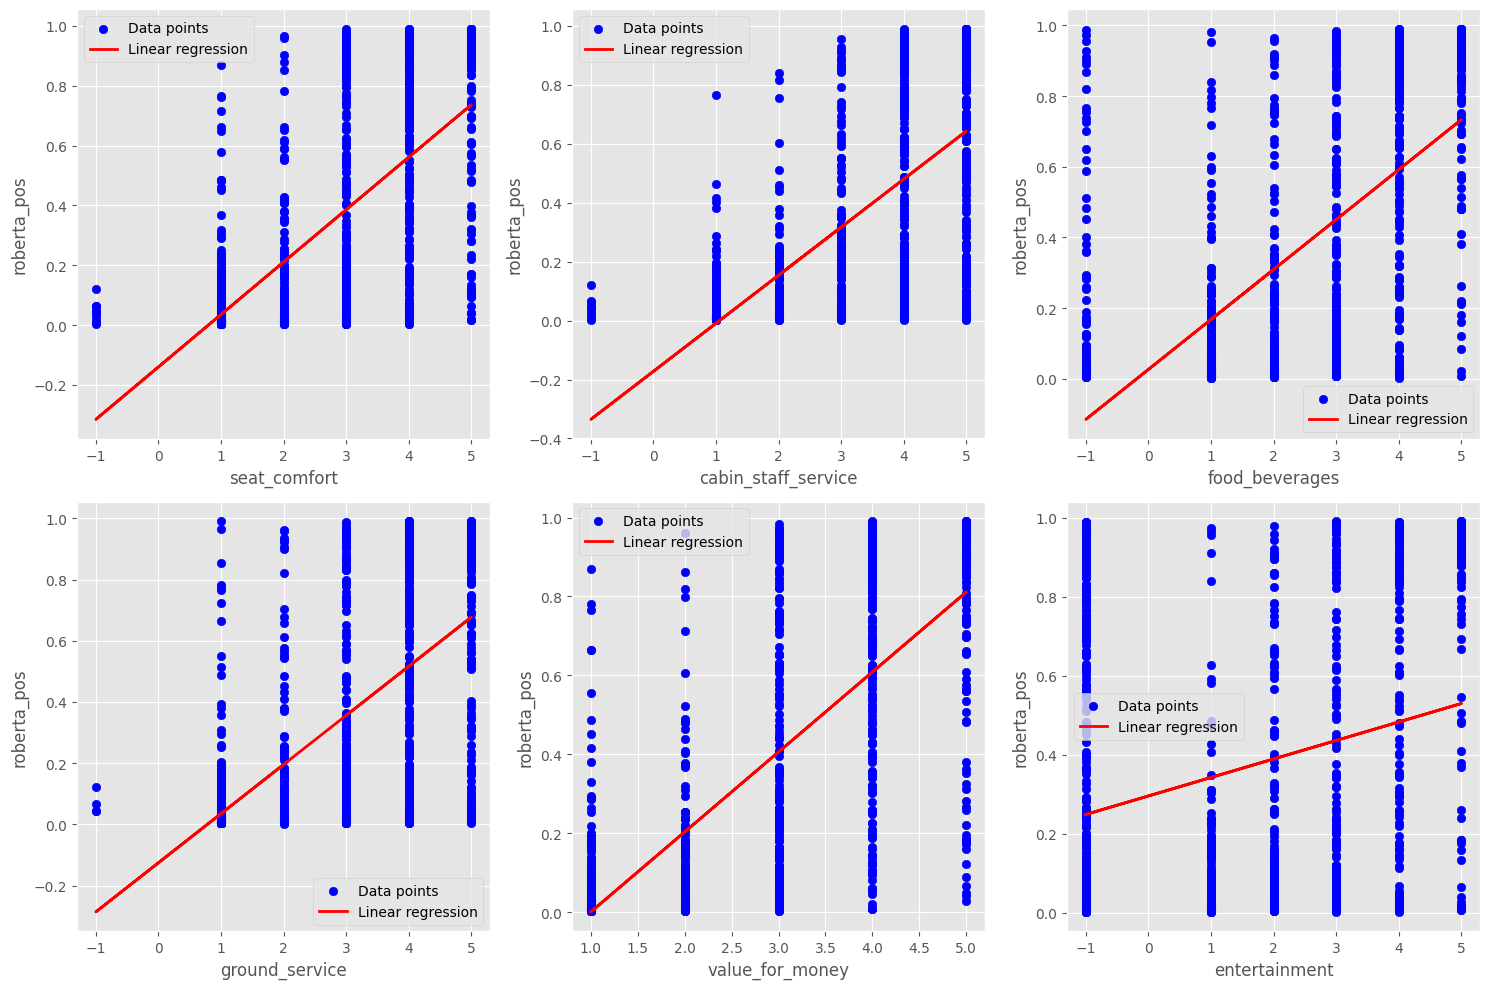

In [ ]:


# Assuming results_df is your DataFrame with columns 'independent_var1' through 'independent_var6' and 'dependent_var'
X = results_df[['seat_comfort',	'cabin_staff_service',	'food_beverages',	'ground_service'	,'value_for_money'	,'entertainment']]
y = results_df['roberta_pos']

# Create a linear regression model
regr = LinearRegression()

# Create subplots for each independent variable
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()

# Loop through each independent variable
for i, col in enumerate(X.columns):
    # Scatter plot of the data
    axs[i].scatter(X[col], y, color='blue', label='Data points')

    # Fit the linear regression model
    regr.fit(X[[col]], y)

    # Plot the regression line
    axs[i].plot(X[[col]], regr.predict(X[[col]]), color='red', linewidth=2, label='Linear regression')

    # Set labels and title
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('roberta_pos')
    axs[i].legend()

plt.tight_layout()
plt.show()


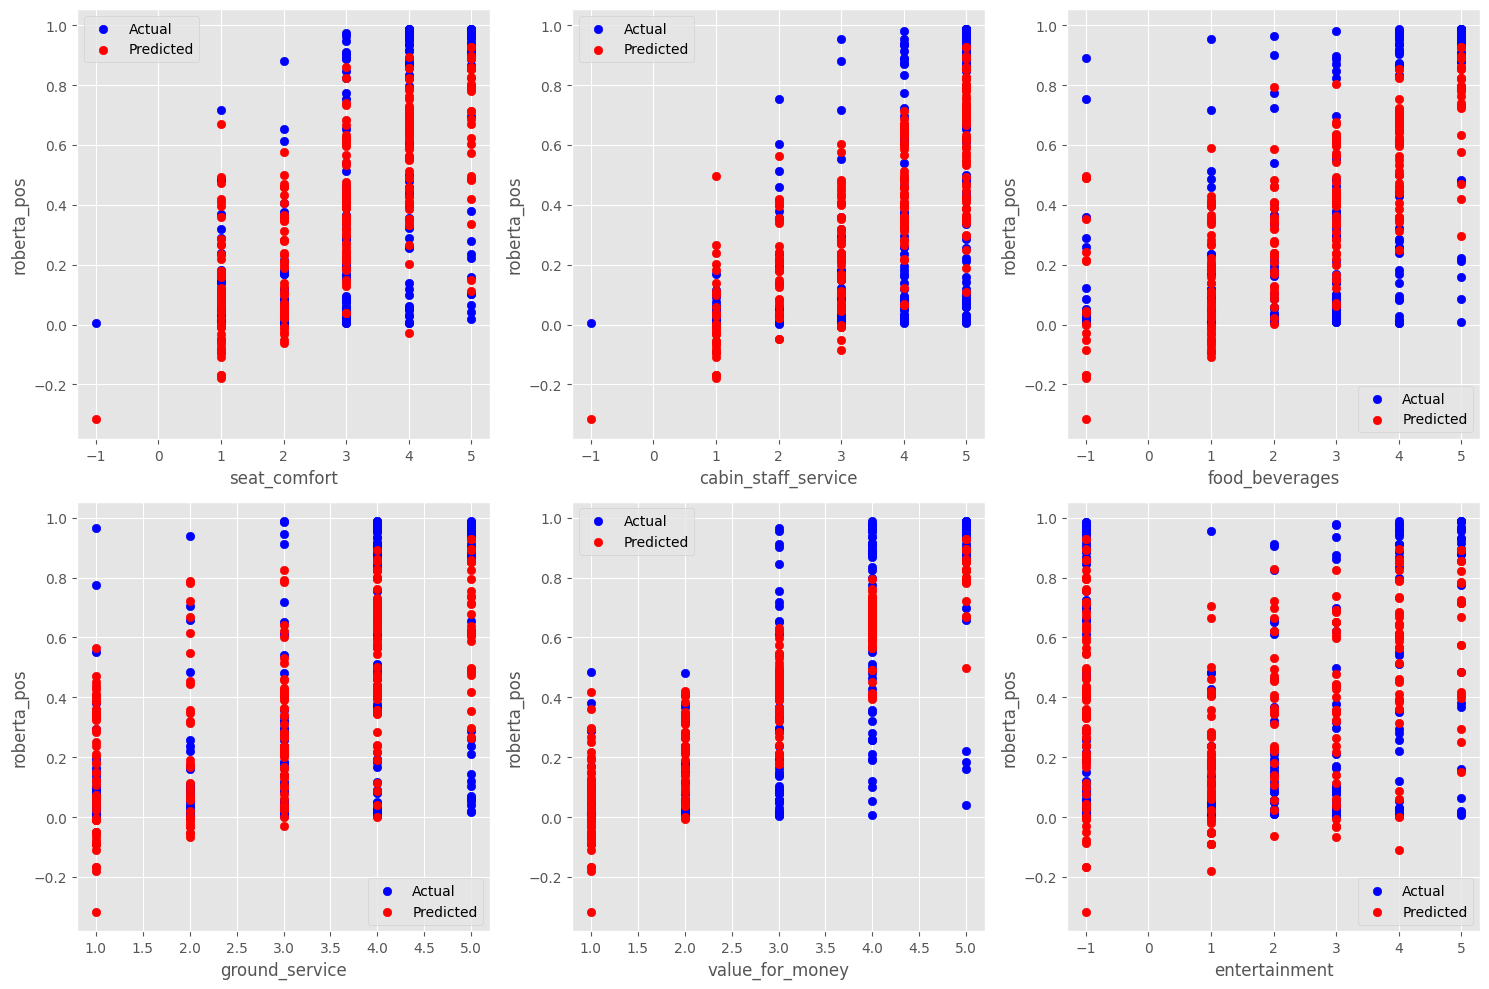

In [ ]:


# Assuming results_df is your DataFrame with columns 'independent_var1' through 'independent_var6' and 'dependent_var'
X = results_df[['seat_comfort',	'cabin_staff_service',	'food_beverages',	'ground_service'	,'value_for_money'	,'entertainment']]
y = results_df['roberta_pos']
from sklearn.model_selection import train_test_split
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
regr = LinearRegression()

# Fit the model to the training data
regr.fit(X_train, y_train)

# Predict on the testing data
y_pred = regr.predict(X_test)

# Plotting actual vs predicted for each independent variable
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()

for i, col in enumerate(X.columns):
    axs[i].scatter(X_test[col], y_test, color='blue', label='Actual')
    axs[i].scatter(X_test[col], y_pred, color='red', label='Predicted')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('roberta_pos')
    axs[i].legend()

plt.tight_layout()
plt.show()


In [ ]:
results_df.corr()

<ipython-input-16-419e2a40607f>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  results_df.corr()


,roberta_neg,roberta_neu,roberta_pos,rating,seat_comfort,cabin_staff_service,food_beverages,ground_service,value_for_money,entertainment
roberta_neg,1.000000,-0.042108,-0.927694,-0.005067,-0.641812,-0.656334,-0.588935,-0.590056,-0.755307,-0.226165
roberta_neu,-0.042108,1.000000,-0.333946,-0.002729,-0.111343,-0.116671,-0.229953,-0.109890,-0.121896,-0.128532
roberta_pos,-0.927694,-0.333946,1.000000,0.005800,0.647110,0.662801,0.641545,0.597739,0.758127,0.261399
rating,-0.005067,-0.002729,0.005800,1.000000,-0.014026,-0.000519,-0.023138,0.037645,0.007009,0.025536
seat_comfort,-0.641812,-0.111343,0.647110,-0.014026,1.000000,0.626678,0.553229,0.551421,0.691872,0.316689
cabin_staff_service,-0.656334,-0.116671,0.662801,-0.000519,0.626678,1.000000,0.654637,0.509738,0.662671,0.232070
food_beverages,-0.588935,-0.229953,0.641545,-0.023138,0.553229,0.654637,1.000000,0.457083,0.626677,0.408918
ground_service,-0.590056,-0.109890,0.597739,0.037645,0.551421,0.509738,0.457083,1.000000,0.614198,0.242097
value_for_money,-0.755307,-0.121896,0.758127,0.007009,0.691872,0.662671,0.626677,0.614198,1.000000,0.288547
entertainment,-0.226165,-0.128532,0.261399,0.025536,0.316689,0.232070,0.408918,0.242097,0.288547,1.000000


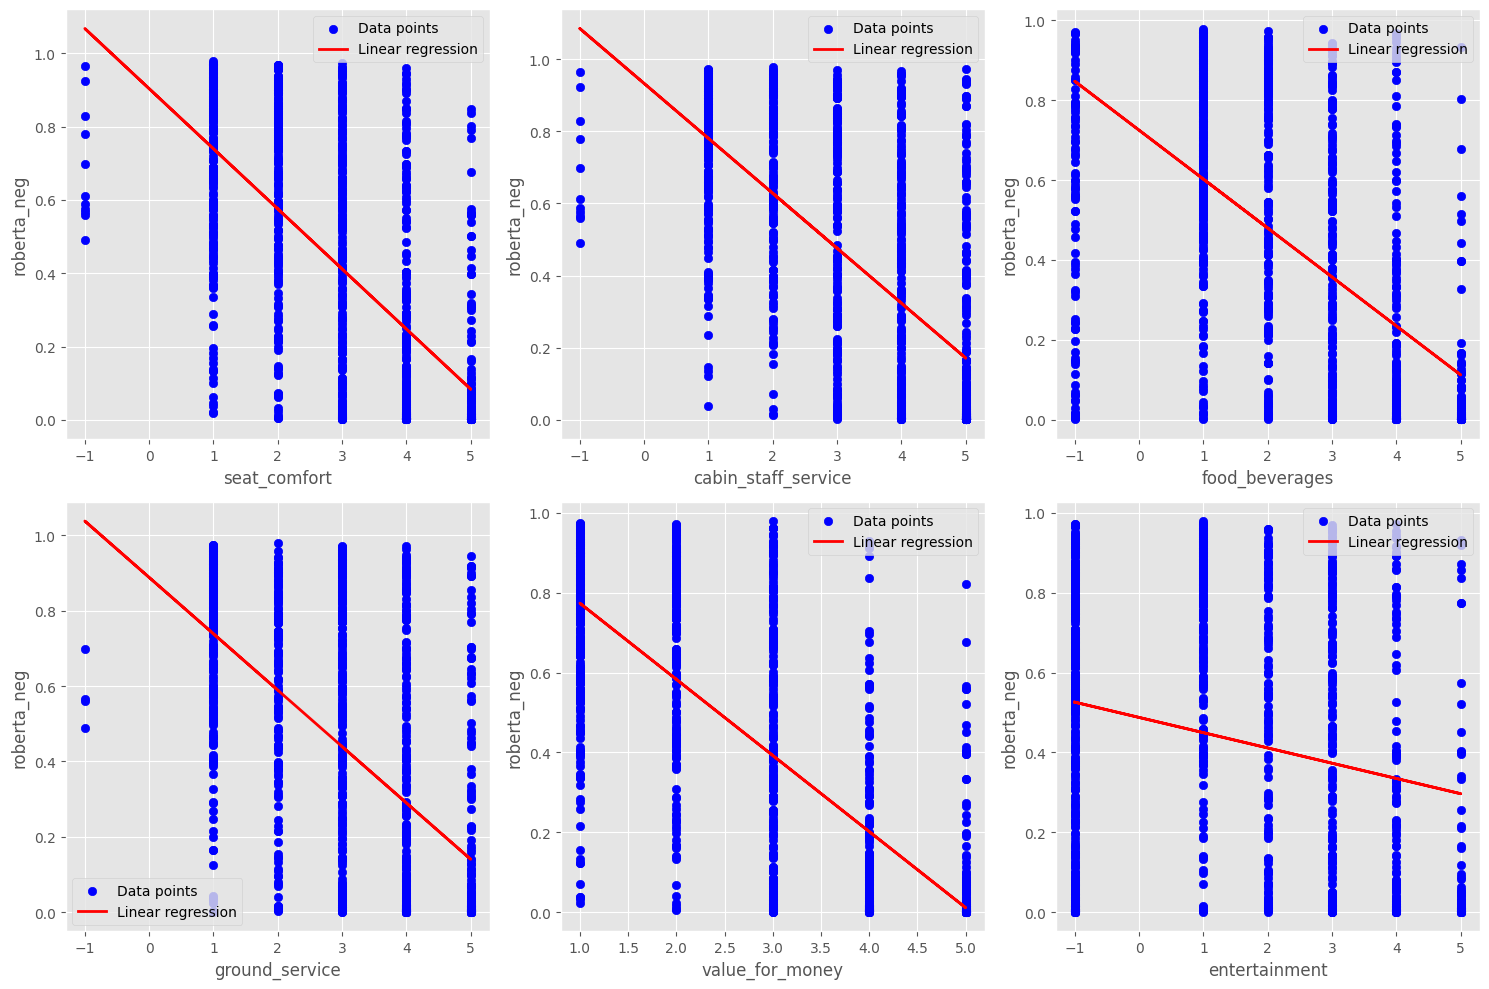

In [ ]:


# Assuming results_df is your DataFrame with columns 'independent_var1' through 'independent_var6' and 'dependent_var'
X = results_df[['seat_comfort',	'cabin_staff_service',	'food_beverages',	'ground_service'	,'value_for_money'	,'entertainment']]
y = results_df['roberta_neg']

# Create a linear regression model
regr = LinearRegression()

# Create subplots for each independent variable
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()

# Loop through each independent variable
for i, col in enumerate(X.columns):
    # Scatter plot of the data
    axs[i].scatter(X[col], y, color='blue', label='Data points')

    # Fit the linear regression model
    regr.fit(X[[col]], y)

    # Plot the regression line
    axs[i].plot(X[[col]], regr.predict(X[[col]]), color='red', linewidth=2, label='Linear regression')

    # Set labels and title
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('roberta_neg')
    axs[i].legend()

plt.tight_layout()
plt.show()


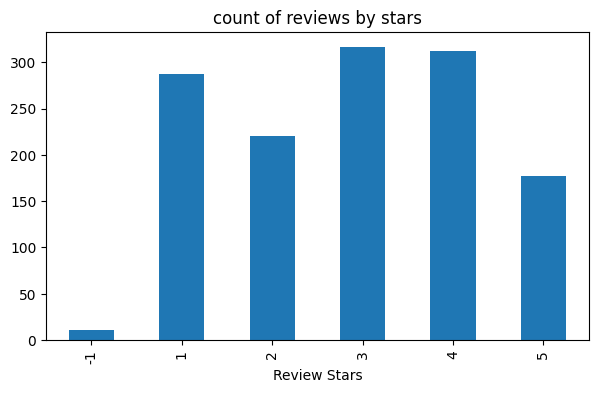

In [ ]:
ax=df['seat_comfort'].value_counts().sort_index().plot(kind='bar',title='count of reviews by stars',figsize=(7,4))
ax.set_xlabel('Review Stars')
plt.show()

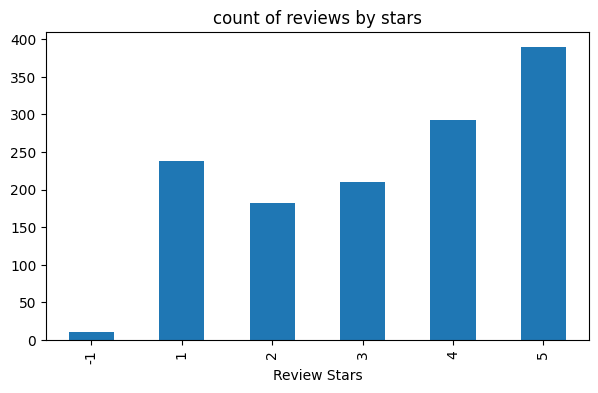

In [ ]:
ax=df['cabin_staff_service'].value_counts().sort_index().plot(kind='bar',title='count of reviews by stars',figsize=(7,4))
ax.set_xlabel('Review Stars')
plt.show()

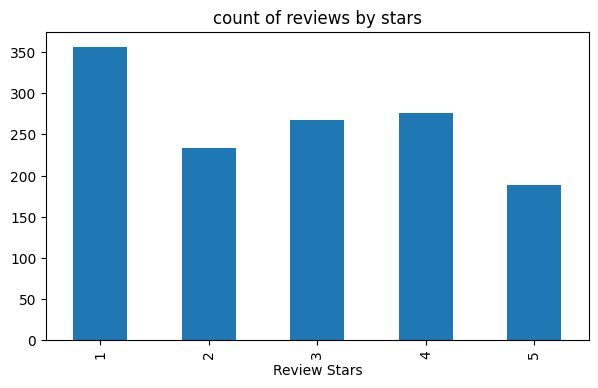

In [ ]:
ax=df['value_for_money'].value_counts().sort_index().plot(kind='bar',title='count of reviews by stars',figsize=(7,4))
ax.set_xlabel('Review Stars')
plt.show()

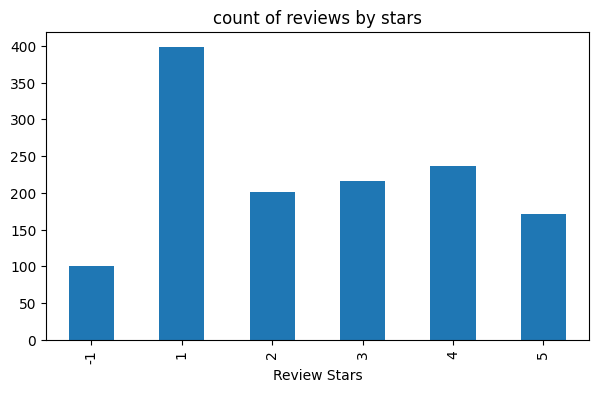

In [ ]:
ax=df['food_beverages'].value_counts().sort_index().plot(kind='bar',title='count of reviews by stars',figsize=(7,4))
ax.set_xlabel('Review Stars')
plt.show()

In [ ]:
def conditions(x):
  if x== 'no' :
    return 0
  else :
    return 1
results_df['recomendation_bin']= results_df['recommended'].apply(conditions)


In [ ]:
results_df.corr()

<ipython-input-93-419e2a40607f>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  results_df.corr()


,roberta_neg,roberta_neu,roberta_pos,rating,seat_comfort,cabin_staff_service,food_beverages,ground_service,value_for_money,entertainment,recomendation_bin
roberta_neg,1.000000,-0.042108,-0.927694,-0.005067,-0.641812,-0.656334,-0.588935,-0.590056,-0.755307,-0.226165,-0.788237
roberta_neu,-0.042108,1.000000,-0.333946,-0.002729,-0.111343,-0.116671,-0.229953,-0.109890,-0.121896,-0.128532,-0.145705
roberta_pos,-0.927694,-0.333946,1.000000,0.005800,0.647110,0.662801,0.641545,0.597739,0.758127,0.261399,0.798092
rating,-0.005067,-0.002729,0.005800,1.000000,-0.014026,-0.000519,-0.023138,0.037645,0.007009,0.025536,-0.009975
seat_comfort,-0.641812,-0.111343,0.647110,-0.014026,1.000000,0.626678,0.553229,0.551421,0.691872,0.316689,0.653460
cabin_staff_service,-0.656334,-0.116671,0.662801,-0.000519,0.626678,1.000000,0.654637,0.509738,0.662671,0.232070,0.644050
food_beverages,-0.588935,-0.229953,0.641545,-0.023138,0.553229,0.654637,1.000000,0.457083,0.626677,0.408918,0.601566
ground_service,-0.590056,-0.109890,0.597739,0.037645,0.551421,0.509738,0.457083,1.000000,0.614198,0.242097,0.577848
value_for_money,-0.755307,-0.121896,0.758127,0.007009,0.691872,0.662671,0.626677,0.614198,1.000000,0.288547,0.779993
entertainment,-0.226165,-0.128532,0.261399,0.025536,0.316689,0.232070,0.408918,0.242097,0.288547,1.000000,0.227408
